In [36]:
import tempfile

from diffpy.structure import Atom, Lattice, Structure
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.tri as tri

# Colorisation and visualisation
from matplotlib.colors import to_rgb
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import Normalize

In [37]:
def load_and_process_data(filepath):
    # Load the data from the file
    data = np.loadtxt(filepath, delimiter='\t', skiprows=1)
    #, max_rows=500000
    # Extract the x, y, z coordinates and the R values
    phase, x, y, z, R_flat = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 7:16]
    # Reshape R_flat into a list of 3x3 matrices
    R_list = [row.reshape(3, 3) for row in R_flat]
    # Stack the 3x3 matrices vertically
    R = np.vstack([r[np.newaxis, :, :] for r in R_list])
    # Calculate the 2-norm of each column for each 3x3 matrix
    norms = np.linalg.norm(R, axis=1, keepdims=True)
    # Normalize each 3x3 matrix by its column norms
    R_normalized = R / norms
    #print(np.shape(R_normalized))
    return phase, x, y, z, R_normalized

In [38]:
def compute_and_count_step_sizes(x, z):
    step_sizes = []
    current_z = z[0]  # 初始值为第一个z
    index_start = 0

    # 遍历z的每个值
    for i in range(1, len(z)):
        if z[i] != current_z:
            # 当z值变化时，计算上一个层的步长
            layer_x = x[index_start:i]
            if len(layer_x) > 1:
                x_step = round(layer_x[1] - layer_x[0], 3)
            else:
                x_step = 0  # 如果只有一个点，步长为0
            step_sizes.append((current_z, x_step))
            #print(f"Layer z={current_z}: step_size={x_step}")

            # 更新当前z和起始索引
            current_z = z[i]
            index_start = i

    # 处理最后一层
    layer_x = x[index_start:]
    if len(layer_x) > 1:
        x_step = round(layer_x[1] - layer_x[0], 3)
    else:
        x_step = 0
    step_sizes.append((current_z, x_step))
    
    # 统计步长出现的次数
    step_count = {}
    for _, step in step_sizes:
        if step in step_count:
            step_count[step] += 1
        else:
            step_count[step] = 1

    # 打印步长和出现次数
    for step, count in step_count.items():
        print(f"Step size {step} appears {count} times")

    return step_sizes, step_count

In [39]:
def compute_dislocation_density_from_ebsd(x, y, z, R_flat):
    
    n_points = len(x)
    alpha = np.zeros((n_points - 1, 3, 3, 3))  # 初始化位错密度张量
    
    for i in range(n_points - 1):
        xi, yi, zi = x[i], y[i], z[i]
        Ri = R_flat[i].reshape(3, 3)  # 当前点的取向矩阵

        xi1, yi1, zi1 = x[i + 1], y[i + 1], z[i + 1]
        Ri1 = R_flat[i + 1].reshape(3, 3)  # 相邻点的取向矩阵

        delta_x = xi1 - xi
        delta_y = yi1 - yi
        delta_z = zi1 - zi

        dx = np.sqrt(delta_x**2 + delta_y**2 + delta_z**2)

        # 计算旋转张量g
        g = np.dot(Ri1, Ri.T)

        # 计算每个方向上的偏导数并更新位错密度张量
        for j in range(3):
            partial_g = np.gradient(g[:, j], dx, axis=0)  # 对于 g 的每一列计算梯度
            for k in range(3):
                alpha[i, j, k, :] = np.cross(partial_g, np.eye(3)[k])

    return alpha

In [40]:
def plot_3d_density(phase, x, y, z, alpha):
    # 将 dislocation_density 的长度调整为与 x, y, z 一致
    dislocation_density = alpha[:len(x) - 1]

    # 使用 mask 过滤掉 phase 为 0 的点
    mask = phase[:-1] != 0
    x = x[:-1][mask]
    y = y[:-1][mask]
    z = z[:-1][mask]
    dislocation_density = dislocation_density[mask]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 归一化 dislocation_density，使其值在 0-1 范围内
    dislocation_density_n = (dislocation_density - np.min(dislocation_density)) / (np.max(dislocation_density) - np.min(dislocation_density))

    # 使用 dislocation_density 的值作为颜色映射
    scatter = ax.scatter(x, y, z, c=dislocation_density_n, cmap='viridis', alpha=1, s=1)

    # 添加颜色条
    fig.colorbar(scatter, ax=ax, label='Dislocation Density')

    # 设置坐标轴范围
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    ax.set_zlim(0, 20)

    plt.show()

In [41]:
def main():
    # Specify the filepath to the data file
    filepath = '3d_ebsd_20240619_R_appended_data.txt'
    # Load and process the data
    phase, x, y, z, R_normalized = load_and_process_data(filepath)
    # 计算每一层的步长
    step_sizes, step_count = compute_and_count_step_sizes(x, z)
    # 计算位错密度
    alpha = compute_dislocation_density_from_ebsd(x, y, z, R_normalized)
    # Plot the processed data
    plot_3d_density(phase, x, y, z, np.linalg.norm(alpha, axis=(2, 3)))

Step size 0.051 appears 149 times
Step size 0.05 appears 30 times
Step size 0.087 appears 5 times
Step size 0.033 appears 2 times
Step size 0.066 appears 1 times
Step size 0.049 appears 1 times
Step size 0.017 appears 1 times
Step size 0.027 appears 1 times
Step size 0.083 appears 1 times
Step size 0.073 appears 1 times


/var/folders/ww/5vsdwswx1t510sdhmkz3673r0000gn/T/ipykernel_24704/3523387980.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c=dislocation_density_n, cmap='viridis', alpha=1, s=1)


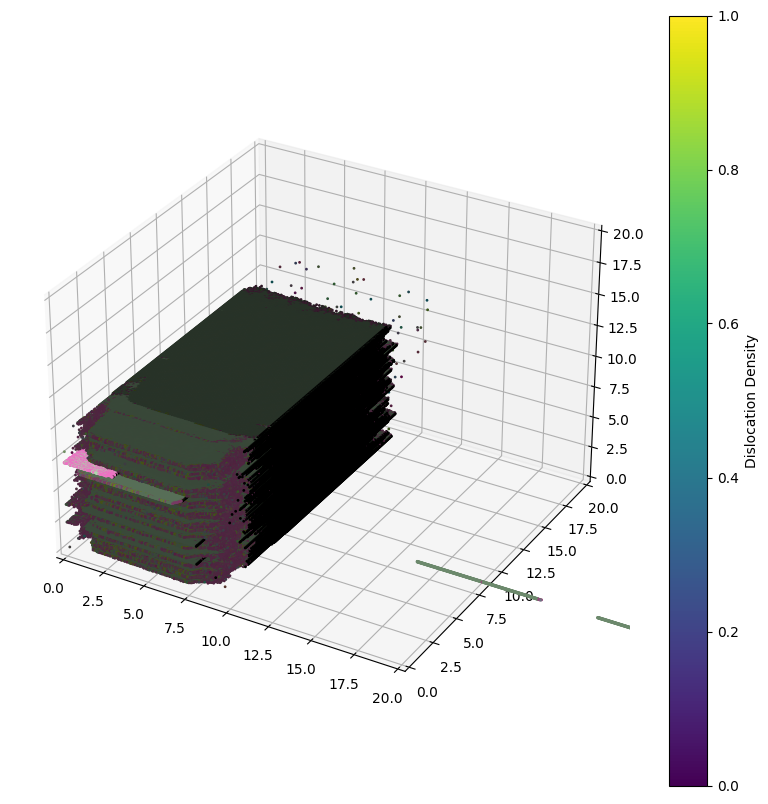

In [42]:
if __name__ == "__main__":
    main()